## Crypto Prediction with LSTM: BitCoin (BTC)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-10-23 14:53:18.795502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-10-23T00:00:00.0000000Z', 'time_period_end': '2023-10-24T00:00:00.0000000Z', 'time_open': '2023-10-23T00:00:24.0400000Z', 'time_close': '2023-10-23T18:53:20.6140000Z', 'price_open': 30007, 'price_high': 31328, 'price_low': 29898, 'price_close': 31130, 'volume_traded': 2562.66191112, 'trades_count': 15876}, {'time_period_start': '2023-10-22T00:00:00.0000000Z', 'time_period_end': '2023-10-23T00:00:00.0000000Z', 'time_open': '2023-10-22T00:00:25.8030000Z', 'time_close': '2023-10-22T23:59:41.1330000Z', 'price_open': 29921, 'price_high': 30247, 'price_low': 29678, 'price_close': 30002, 'volume_traded': 918.65122289, 'trades_count': 8652}, {'time_period_start': '2023-10-21T00:00:00.0000000Z', 'time_period_end': '2023-10-22T00:00:00.0000000Z', 'time_open': '2023-10-21T00:00:08.2050000Z', 'time_close': '2023-10-21T23:59:19.6030000Z', 'price_open': 29682, 'price_high': 30357, 'price_low': 29483, 'price_close': 29927, 'volume_traded': 899.1075086, 'trades_count': 913

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-10-23T00:00:00.0000000Z,2023-10-24T00:00:00.0000000Z,2023-10-23T00:00:24.0400000Z,2023-10-23T18:53:20.6140000Z,30007.0,31328.0,29898.0,31130.0,2562.661911,15876
1,2023-10-22T00:00:00.0000000Z,2023-10-23T00:00:00.0000000Z,2023-10-22T00:00:25.8030000Z,2023-10-22T23:59:41.1330000Z,29921.0,30247.0,29678.0,30002.0,918.651223,8652
2,2023-10-21T00:00:00.0000000Z,2023-10-22T00:00:00.0000000Z,2023-10-21T00:00:08.2050000Z,2023-10-21T23:59:19.6030000Z,29682.0,30357.0,29483.0,29927.0,899.107509,9138
3,2023-10-20T00:00:00.0000000Z,2023-10-21T00:00:00.0000000Z,2023-10-20T00:00:09.2300000Z,2023-10-20T23:59:38.6920000Z,28734.0,30233.0,28595.0,29688.0,2764.093500,16147
4,2023-10-19T00:00:00.0000000Z,2023-10-20T00:00:00.0000000Z,2023-10-19T00:00:06.1560000Z,2023-10-19T23:59:53.9150000Z,28327.0,28916.0,28138.0,28733.0,1523.591536,11002


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87


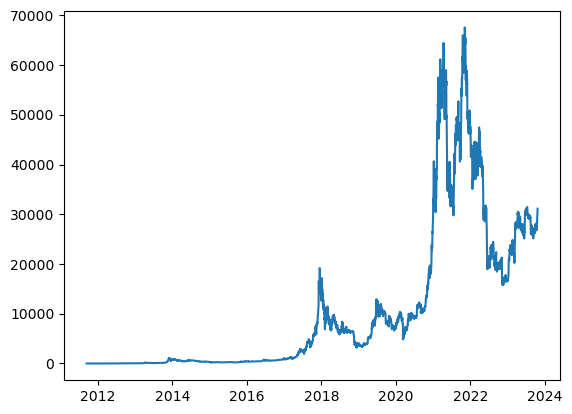

In [5]:
#plot historical amzn price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#Scale data
log_transformed_data = np.log(shifted_df_as_np)



# split reference from deatures
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((4264, 7), (4264,), (4264,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3411, 7), (3411,), (426, 7), (426,), (427, 7), (427,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-10-23 14:53:26.493215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
107/107 [==============================] - 4s 15ms/step - loss: 11.0348 - mean_absolute_error: 2.1471 - val_loss: 0.1425 - val_mean_absolute_error: 0.3581
Epoch 2/100
107/107 [==============================] - 1s 7ms/step - loss: 0.0083 - mean_absolute_error: 0.0625 - val_loss: 0.0055 - val_mean_absolute_error: 0.0586
Epoch 3/100
107/107 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_absolute_error: 0.0506 - val_loss: 0.0086 - val_mean_absolute_error: 0.0786
Epoch 4/100
107/107 [==============================] - 1s 9ms/step - loss: 0.0052 - mean_absolute_error: 0.0510 - val_loss: 0.0038 - val_mean_absolute_error: 0.0476
Epoch 5/100
107/107 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_absolute_error: 0.0517 - val_loss: 0.0117 - val_mean_absolute_error: 0.0925
Epoch 6/100
107/107 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_absolute_error: 0.0499 - val_loss: 0.0031 - val_mean_absolute_error: 0.0433
Epoch

107/107 [==============================] - 1s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0447 - val_loss: 0.0102 - val_mean_absolute_error: 0.0934
Epoch 51/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0408 - val_loss: 0.0031 - val_mean_absolute_error: 0.0466
Epoch 52/100
107/107 [==============================] - 1s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0438 - val_loss: 0.0015 - val_mean_absolute_error: 0.0298
Epoch 53/100
107/107 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0379 - val_loss: 0.0027 - val_mean_absolute_error: 0.0411
Epoch 54/100
107/107 [==============================] - 1s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0392 - val_loss: 0.0068 - val_mean_absolute_error: 0.0736
Epoch 55/100
107/107 [==============================] - 1s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0391 - val_loss: 0.0044 - val_mean_absolute_error: 0.0566
Epoch 56/100
107/

107/107 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0385 - val_loss: 0.0017 - val_mean_absolute_error: 0.0318
Epoch 100/100
107/107 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0378 - val_loss: 0.0019 - val_mean_absolute_error: 0.0347


107/107 [==============================] - 1s 2ms/step


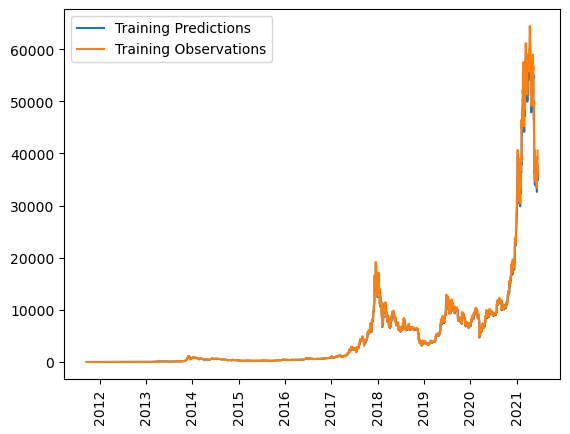

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0018868005136027932
Val MAE: 0.03470641002058983


14/14 [==============================] - 0s 3ms/step


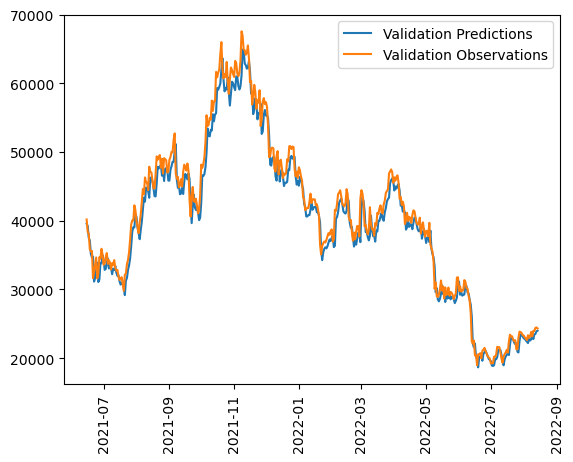

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0010583889670670033
Test MAE: 0.025415625423192978


14/14 [==============================] - 0s 5ms/step


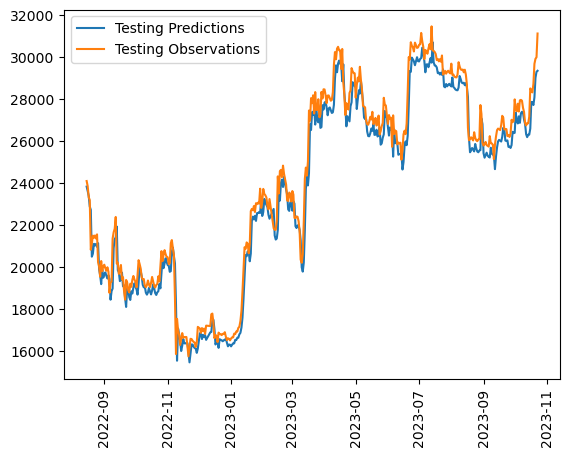

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9731610388378831


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((1662,),
 (1662, 7),
 (1662,),
 (256,),
 (256, 7),
 (256,),
 (214,),
 (214, 7),
 (214,))

In [26]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
107/107 [==============================] - 8s 28ms/step - loss: 9.6357 - mean_absolute_error: 1.9527 - val_loss: 0.1515 - val_mean_absolute_error: 0.3654
Epoch 2/300
107/107 [==============================] - 1s 10ms/step - loss: 0.0080 - mean_absolute_error: 0.0588 - val_loss: 0.0095 - val_mean_absolute_error: 0.0777
Epoch 3/300
107/107 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_absolute_error: 0.0440 - val_loss: 0.0054 - val_mean_absolute_error: 0.0586
Epoch 4/300
107/107 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_absolute_error: 0.0535 - val_loss: 0.0051 - val_mean_absolute_error: 0.0569
Epoch 5/300
107/107 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_absolute_error: 0.0456 - val_loss: 0.0033 - val_mean_absolute_error: 0.0447
Epoch 6/300
107/107 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_absolute_error: 0.0444 - val_loss: 0.0038 - val_mean_absolute_error: 0.0480
Epoc

107/107 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_absolute_error: 0.0377 - val_loss: 0.0023 - val_mean_absolute_error: 0.0370
Epoch 51/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0421 - val_loss: 0.0018 - val_mean_absolute_error: 0.0319
Epoch 52/300
107/107 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_absolute_error: 0.0414 - val_loss: 0.0036 - val_mean_absolute_error: 0.0510
Epoch 53/300
107/107 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_absolute_error: 0.0408 - val_loss: 0.0025 - val_mean_absolute_error: 0.0403
Epoch 54/300
107/107 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_absolute_error: 0.0372 - val_loss: 0.0049 - val_mean_absolute_error: 0.0620
Epoch 55/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0035 - mean_absolute_error: 0.0417 - val_loss: 0.0021 - val_mean_absolute_error: 0.0351
Epoch 56/300


107/107 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_absolute_error: 0.0405 - val_loss: 0.0013 - val_mean_absolute_error: 0.0267
Epoch 100/300
107/107 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_absolute_error: 0.0393 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302
Epoch 101/300
107/107 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_absolute_error: 0.0413 - val_loss: 0.0013 - val_mean_absolute_error: 0.0265
Epoch 102/300
107/107 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_absolute_error: 0.0373 - val_loss: 0.0018 - val_mean_absolute_error: 0.0330
Epoch 103/300
107/107 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_absolute_error: 0.0427 - val_loss: 0.0028 - val_mean_absolute_error: 0.0450
Epoch 104/300
107/107 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_absolute_error: 0.0410 - val_loss: 0.0065 - val_mean_absolute_error: 0.0742
Epoch 

107/107 [==============================] - 1s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0341 - val_loss: 0.0013 - val_mean_absolute_error: 0.0265
Epoch 149/300
107/107 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0372 - val_loss: 0.0036 - val_mean_absolute_error: 0.0507
Epoch 150/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0432 - val_loss: 0.0039 - val_mean_absolute_error: 0.0534
Epoch 151/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0034 - mean_absolute_error: 0.0402 - val_loss: 0.0027 - val_mean_absolute_error: 0.0441
Epoch 152/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0033 - mean_absolute_error: 0.0405 - val_loss: 0.0046 - val_mean_absolute_error: 0.0602
Epoch 153/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0341 - val_loss: 0.0013 - val_mean_absolute_error: 0.0268
Epoch 154/30

107/107 [==============================] - 1s 9ms/step - loss: 0.0036 - mean_absolute_error: 0.0420 - val_loss: 0.0046 - val_mean_absolute_error: 0.0589
Epoch 198/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0034 - mean_absolute_error: 0.0403 - val_loss: 0.0019 - val_mean_absolute_error: 0.0351
Epoch 199/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0350 - val_loss: 0.0042 - val_mean_absolute_error: 0.0555
Epoch 200/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0030 - mean_absolute_error: 0.0364 - val_loss: 0.0059 - val_mean_absolute_error: 0.0700
Epoch 201/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0342 - val_loss: 0.0013 - val_mean_absolute_error: 0.0266
Epoch 202/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0383 - val_loss: 0.0069 - val_mean_absolute_error: 0.0755
Epoch 203/30

107/107 [==============================] - 1s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0344 - val_loss: 0.0014 - val_mean_absolute_error: 0.0276
Epoch 247/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0351 - val_loss: 0.0014 - val_mean_absolute_error: 0.0270
Epoch 248/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0389 - val_loss: 0.0014 - val_mean_absolute_error: 0.0290
Epoch 249/300
107/107 [==============================] - 1s 10ms/step - loss: 0.0027 - mean_absolute_error: 0.0337 - val_loss: 0.0034 - val_mean_absolute_error: 0.0507
Epoch 250/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0354 - val_loss: 0.0028 - val_mean_absolute_error: 0.0445
Epoch 251/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0382 - val_loss: 0.0014 - val_mean_absolute_error: 0.0288
Epoch 252/3

107/107 [==============================] - 1s 9ms/step - loss: 0.0029 - mean_absolute_error: 0.0369 - val_loss: 0.0018 - val_mean_absolute_error: 0.0330
Epoch 296/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0029 - mean_absolute_error: 0.0366 - val_loss: 0.0026 - val_mean_absolute_error: 0.0418
Epoch 297/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0354 - val_loss: 0.0015 - val_mean_absolute_error: 0.0286
Epoch 298/300
107/107 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_absolute_error: 0.0388 - val_loss: 0.0041 - val_mean_absolute_error: 0.0561
Epoch 299/300
107/107 [==============================] - 1s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0343 - val_loss: 0.0015 - val_mean_absolute_error: 0.0289
Epoch 300/300
107/107 [==============================] - 1s 10ms/step - loss: 0.0029 - mean_absolute_error: 0.0365 - val_loss: 0.0014 - val_mean_absolute_error: 0.0288


52/52 [==============================] - 1s 4ms/step


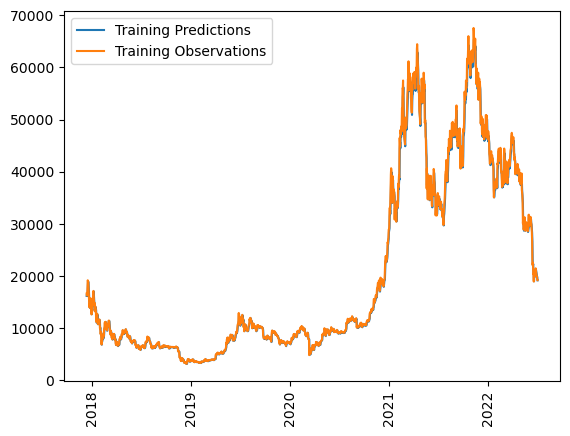

In [27]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [28]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0010059491032734513
Val MAE: 0.02096935361623764


8/8 [==============================] - 0s 4ms/step


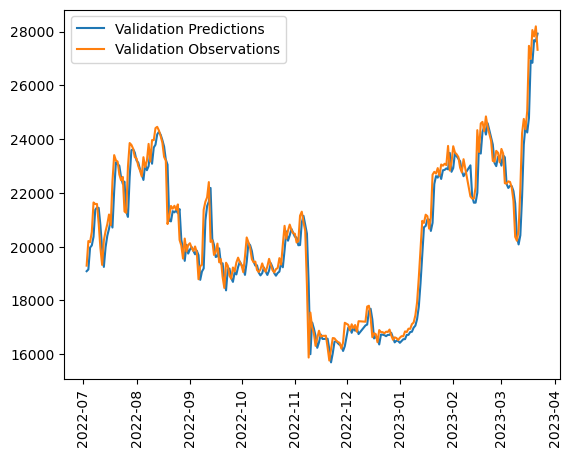

In [29]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [30]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0004333374963607639
Test MAE: 0.01512385718524456


In [31]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

7/7 [==============================] - 0s 4ms/step
R2 Score:  0.8610263710080993


7/7 [==============================] - 0s 5ms/step


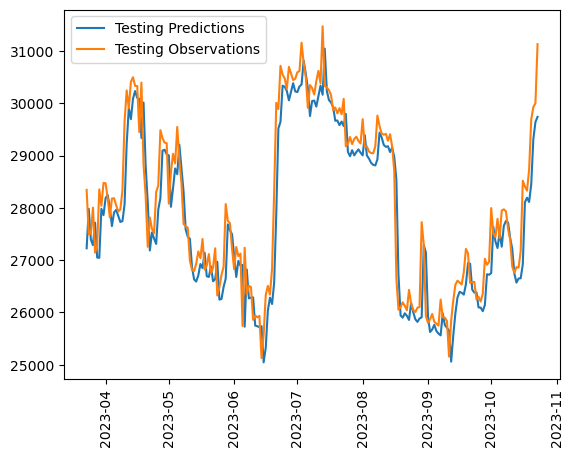

In [32]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [57]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=500)

Epoch 1/500
52/52 [==============================] - 3s 16ms/step - loss: 26.0136 - mean_absolute_error: 3.9553 - val_loss: 0.9271 - val_mean_absolute_error: 0.9539
Epoch 2/500
52/52 [==============================] - 0s 7ms/step - loss: 0.7590 - mean_absolute_error: 0.7415 - val_loss: 0.1592 - val_mean_absolute_error: 0.3779
Epoch 3/500
52/52 [==============================] - 0s 7ms/step - loss: 0.6402 - mean_absolute_error: 0.7048 - val_loss: 0.1232 - val_mean_absolute_error: 0.3292
Epoch 4/500
52/52 [==============================] - 0s 7ms/step - loss: 0.5088 - mean_absolute_error: 0.6221 - val_loss: 0.0563 - val_mean_absolute_error: 0.2184
Epoch 5/500
52/52 [==============================] - 0s 7ms/step - loss: 0.1083 - mean_absolute_error: 0.2299 - val_loss: 0.0076 - val_mean_absolute_error: 0.0762
Epoch 6/500
52/52 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_absolute_error: 0.0563 - val_loss: 0.0025 - val_mean_absolute_error: 0.0376
Epoch 7/500
52/52 [=

Epoch 51/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0457 - val_loss: 0.0032 - val_mean_absolute_error: 0.0458
Epoch 52/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_absolute_error: 0.0496 - val_loss: 0.0041 - val_mean_absolute_error: 0.0543
Epoch 53/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0585 - val_loss: 0.0051 - val_mean_absolute_error: 0.0618
Epoch 54/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0514 - val_loss: 0.0047 - val_mean_absolute_error: 0.0590
Epoch 55/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0038 - mean_absolute_error: 0.0466 - val_loss: 0.0019 - val_mean_absolute_error: 0.0315
Epoch 56/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0438 - val_loss: 0.0043 - val_mean_absolute_error: 0.0568
Epoch 57/500
52/

Epoch 101/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0433 - val_loss: 0.0037 - val_mean_absolute_error: 0.0531
Epoch 102/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0418 - val_loss: 0.0013 - val_mean_absolute_error: 0.0248
Epoch 103/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0444 - val_loss: 0.0015 - val_mean_absolute_error: 0.0268
Epoch 104/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0415 - val_loss: 0.0023 - val_mean_absolute_error: 0.0391
Epoch 105/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0412 - val_loss: 0.0027 - val_mean_absolute_error: 0.0437
Epoch 106/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0430 - val_loss: 0.0023 - val_mean_absolute_error: 0.0386
Epoch 107/

Epoch 151/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0389 - val_loss: 0.0011 - val_mean_absolute_error: 0.0217
Epoch 152/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0499 - val_loss: 0.0075 - val_mean_absolute_error: 0.0809
Epoch 153/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0476 - val_loss: 0.0011 - val_mean_absolute_error: 0.0230
Epoch 154/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0374 - val_loss: 0.0011 - val_mean_absolute_error: 0.0230
Epoch 155/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0429 - val_loss: 0.0011 - val_mean_absolute_error: 0.0226
Epoch 156/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0396 - val_loss: 0.0033 - val_mean_absolute_error: 0.0505
Epoch 157/

52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0414 - val_loss: 0.0013 - val_mean_absolute_error: 0.0284
Epoch 201/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0488 - val_loss: 0.0020 - val_mean_absolute_error: 0.0373
Epoch 202/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0405 - val_loss: 0.0018 - val_mean_absolute_error: 0.0344
Epoch 203/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_absolute_error: 0.0369 - val_loss: 0.0014 - val_mean_absolute_error: 0.0293
Epoch 204/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0380 - val_loss: 0.0012 - val_mean_absolute_error: 0.0262
Epoch 205/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0386 - val_loss: 0.0016 - val_mean_absolute_error: 0.0308
Epoch 206/500
52/52 [===

Epoch 250/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0056 - val_mean_absolute_error: 0.0702
Epoch 251/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0399 - val_loss: 0.0045 - val_mean_absolute_error: 0.0613
Epoch 252/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0363 - val_loss: 0.0012 - val_mean_absolute_error: 0.0256
Epoch 253/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0389 - val_loss: 0.0032 - val_mean_absolute_error: 0.0506
Epoch 254/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0423 - val_loss: 0.0027 - val_mean_absolute_error: 0.0455
Epoch 255/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0403 - val_loss: 0.0014 - val_mean_absolute_error: 0.0287
Epoch 256/

52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0420 - val_loss: 0.0056 - val_mean_absolute_error: 0.0696
Epoch 300/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0447 - val_loss: 0.0016 - val_mean_absolute_error: 0.0315
Epoch 301/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0370 - val_loss: 0.0023 - val_mean_absolute_error: 0.0408
Epoch 302/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_absolute_error: 0.0357 - val_loss: 9.4115e-04 - val_mean_absolute_error: 0.0204
Epoch 303/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0423 - val_loss: 0.0020 - val_mean_absolute_error: 0.0367
Epoch 304/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0382 - val_loss: 0.0011 - val_mean_absolute_error: 0.0219
Epoch 305/500
52/52 

52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0430 - val_loss: 0.0013 - val_mean_absolute_error: 0.0260
Epoch 349/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0379 - val_loss: 0.0023 - val_mean_absolute_error: 0.0413
Epoch 350/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_absolute_error: 0.0370 - val_loss: 0.0036 - val_mean_absolute_error: 0.0540
Epoch 351/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_absolute_error: 0.0354 - val_loss: 0.0011 - val_mean_absolute_error: 0.0239
Epoch 352/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0367 - val_loss: 0.0010 - val_mean_absolute_error: 0.0225
Epoch 353/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0387 - val_loss: 9.4504e-04 - val_mean_absolute_error: 0.0204
Epoch 354/500
52/52 

52/52 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0483 - val_loss: 0.0010 - val_mean_absolute_error: 0.0216
Epoch 398/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0328 - val_loss: 9.6150e-04 - val_mean_absolute_error: 0.0211
Epoch 399/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0345 - val_loss: 0.0012 - val_mean_absolute_error: 0.0265
Epoch 400/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0355 - val_loss: 0.0018 - val_mean_absolute_error: 0.0354
Epoch 401/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0429 - val_loss: 0.0043 - val_mean_absolute_error: 0.0598
Epoch 402/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0387 - val_loss: 0.0016 - val_mean_absolute_error: 0.0319
Epoch 403/500
52/52 

52/52 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0346 - val_loss: 0.0011 - val_mean_absolute_error: 0.0236
Epoch 447/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0341 - val_loss: 9.4166e-04 - val_mean_absolute_error: 0.0206
Epoch 448/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0398 - val_loss: 0.0017 - val_mean_absolute_error: 0.0331
Epoch 449/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0355 - val_loss: 9.4951e-04 - val_mean_absolute_error: 0.0204
Epoch 450/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0391 - val_loss: 0.0031 - val_mean_absolute_error: 0.0496
Epoch 451/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0477 - val_loss: 0.0013 - val_mean_absolute_error: 0.0273
Epoch 452/500
52

52/52 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0501 - val_loss: 0.0020 - val_mean_absolute_error: 0.0375
Epoch 496/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_absolute_error: 0.0361 - val_loss: 9.3058e-04 - val_mean_absolute_error: 0.0203
Epoch 497/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0377 - val_loss: 0.0030 - val_mean_absolute_error: 0.0485
Epoch 498/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0392 - val_loss: 0.0012 - val_mean_absolute_error: 0.0245
Epoch 499/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0391 - val_loss: 0.0017 - val_mean_absolute_error: 0.0334
Epoch 500/500
52/52 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0387 - val_loss: 9.9619e-04 - val_mean_absolute_error: 0.0221


52/52 [==============================] - 1s 2ms/step


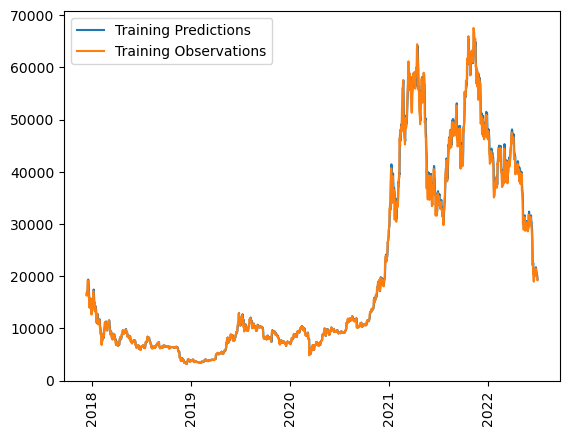

In [58]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [59]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0009961898904293776
Val MAE: 0.022119034081697464


8/8 [==============================] - 0s 2ms/step


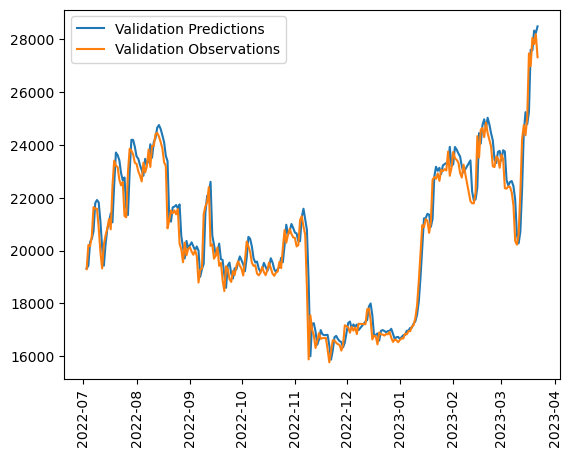

In [60]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [61]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0004750485240947455
Test MAE: 0.017147554084658623


7/7 [==============================] - 0s 2ms/step


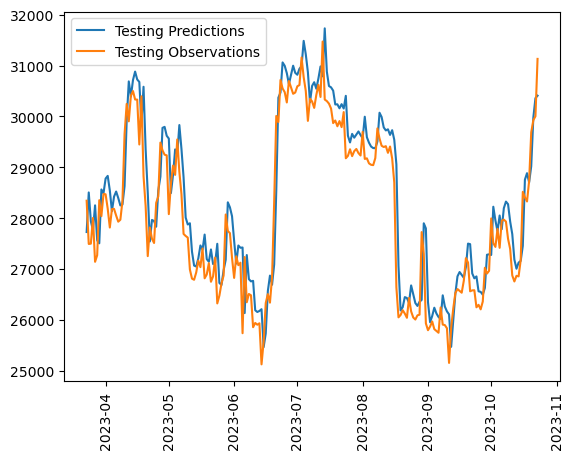

In [62]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [63]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.8476484921511492


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [64]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 32ms/step
[10.287248, 10.285274, 10.286071, 10.286474, 10.286419, 10.286319, 10.2863]
2023-10-24
2023-10-25
2023-10-26
2023-10-27
2023-10-28
2023-10-29
2023-10-30


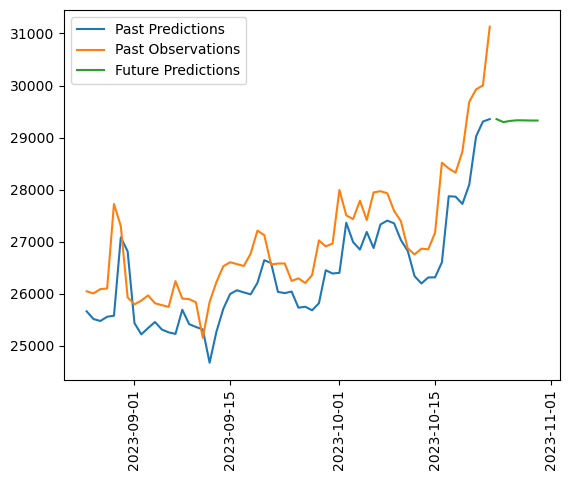

In [65]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [66]:
# Export model1 to HDF5 file
model.save("H5_Files/btc_7_day_1.h5")

In [67]:
# Export model2 to HDF5 file
model2.save("H5_Files/btc_7_day_2.h5")

In [68]:
# Export model to HDF5 file
model3.save("H5_Files/btc_7_day_3.h5")

In [69]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)

# df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
# df2.set_index('Date', inplace=True)                   
                    
# past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-07-26,29354.0,28570.988281,28987.390625,29488.078125
2023-07-27,29219.0,28728.529297,29103.064453,29656.250000
2023-07-28,29317.0,28617.126953,29003.707031,29581.564453
2023-07-29,29360.0,28688.146484,29066.451172,29644.119141
2023-07-30,29279.0,28737.626953,29117.474609,29704.197266
...,...,...,...,...
2023-10-19,28733.0,27726.568359,28112.052734,28701.857422
2023-10-20,29688.0,28094.875000,28449.695312,29020.363281
2023-10-21,29927.0,29022.244141,29312.980469,29978.169922


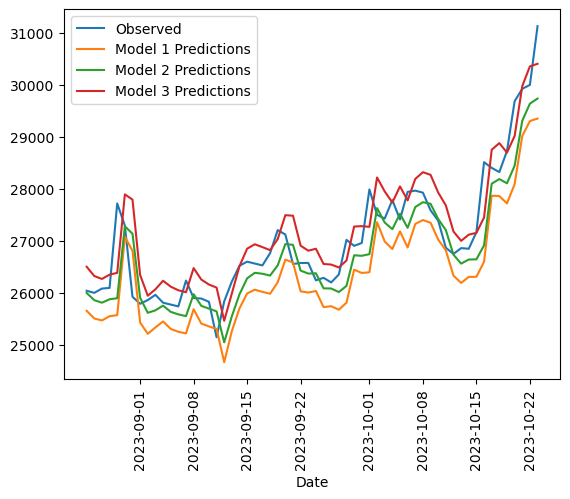

In [70]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [71]:
#output prediction data to csv
df.to_csv('output/btc_predict.csv') 

In [72]:
#output original historical data to csv
data.to_csv('output/btc_lifetime.csv')

In [73]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.9731610388378831
Model 2 R2 Score:  0.8610263710080993
Model 3 R2 Score:  0.8476484921511492
